## Multi-label prediction with Planet Amazon dataset

In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
!pip install kaggle --upgrade

In [0]:
from google.colab import files #upload your kaggle.json file containing your kaggle API key
files.upload() #click on Choose Files and then upload kaggle.json file from your computer

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"aslisabanci","key":"148a7bafd964fbe6f5e16f7580bd1ca1"}'}

In [0]:
!mkdir -p ~/.kaggle #create the .kaggle directory and put your credentials json file into it
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # so that your kaggle.json file cannot be read by others
!ls ~/.kaggle

kaggle.json


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:08<00:00, 117MB/s]
100% 600M/600M [00:08<00:00, 73.8MB/s]
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

In [0]:
 !conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

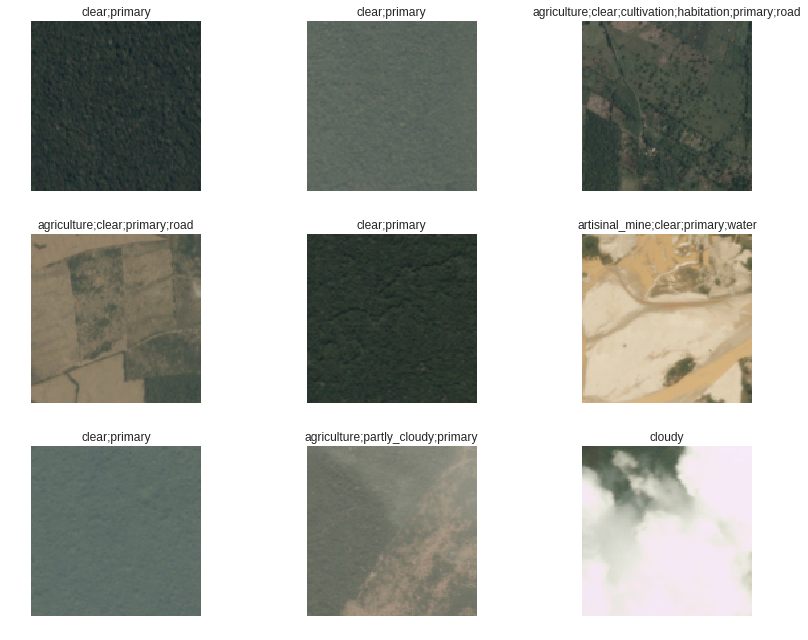

In [0]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18898157.64it/s]


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


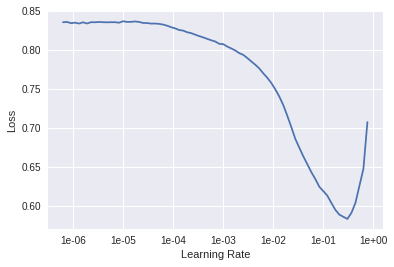

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.124472,0.110371,0.945253,0.900244
2,0.108763,0.096464,0.948203,0.916485
3,0.101710,0.093287,0.956960,0.920657
4,0.092666,0.088183,0.956800,0.925163
5,0.089079,0.086935,0.955884,0.924223


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


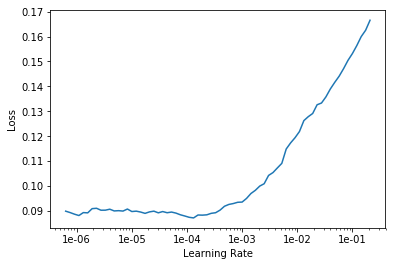

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 05:48
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096917    0.089857    0.964909         0.923028  (01:09)
2      0.095722    0.087677    0.966341         0.924712  (01:09)
3      0.088859    0.085950    0.966813         0.926390  (01:09)
4      0.085320    0.083416    0.967663         0.927521  (01:09)
5      0.081530    0.082129    0.968121         0.928895  (01:09)



In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


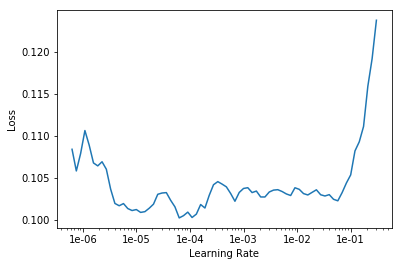

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

Total time: 14:21
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.088628    0.085883    0.966523         0.924035  (02:53)
2      0.089855    0.085019    0.967126         0.926822  (02:51)
3      0.083646    0.083374    0.967583         0.927510  (02:51)
4      0.084014    0.081384    0.968405         0.931110  (02:51)
5      0.083445    0.081085    0.968659         0.930647  (02:52)



In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083591    0.082895    0.968310         0.928210  (03:41)
2      0.088286    0.083184    0.967424         0.928812  (03:40)
3      0.083495    0.083084    0.967998         0.929224  (03:40)
4      0.080143    0.081338    0.968564         0.931363  (03:40)
5      0.074927    0.080691    0.968819         0.931414  (03:41)



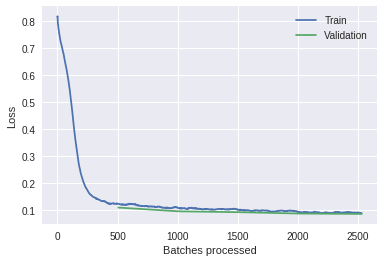

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99% 596M/603M [00:04<00:00, 111MB/s]
100% 603M/603M [00:04<00:00, 145MB/s]


In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
! 7za -bd -y x {path}/test-jpg-additional.tar.7z -o{path}
! tar -xf {path}/test-jpg-additional.tar -C {path}
! rsync -aP {path}/test-jpg-additional/ {path}/test-jpg/

 96% 293M/304M [00:02<00:00, 142MB/s]
100% 304M/304M [00:02<00:00, 128MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs x64)

Scanning the drive for archives:
1 file, 318407195 bytes (304 MiB)

Extracting archive: /root/.fastai/data/planet/test-jpg-additional.tar.7z
--
Path = /root/.fastai/data/planet/test-jpg-additional.tar.7z
Type = 7z
Physical Size = 318407195
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       336865280
Compressed: 318407195
sending incremental file list
./
file_0.jpg
         17,995 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=20521/20523)
file_1.jpg
         18,608 100%   17.75MB/s    0:00:00 (xfr#2, to-chk=20520/20523)
file_10.jpg
          6,980 100%    6.66MB/s    0:00:00 (xfr#3, to-chk=20519/20523)
file_100.jpg
         15,764 100%   15.03MB/s    0:00:00 (xfr#4, to-chk=20518/20523)
file_1000.jpg
         23,725 100%   22.

In [0]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;

Test: LabelList
y: Mul

In [0]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [0]:
!ls /root/.fastai/data/planet/test-jpg | wc

  61191   61191  895645


In [0]:
len(learn.data.test_ds)

61191

In [0]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
len(predictions[0])

61191

In [0]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()
  
def predict(idx):
  pred_vals = predictions[0][idx]
  tags = find_tags(pred_vals, 0.2)
  print(tags)
  img = learn.data.test_ds[idx][0]
  return img

agriculture clear cultivation haze primary water


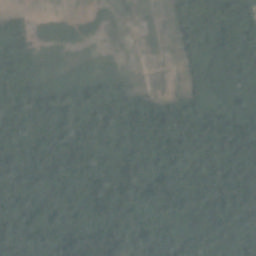

In [0]:
predict(0)

In [0]:
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [0]:
get_row(4)

('test_20779', 'agriculture partly_cloudy primary')

In [0]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 5000
Completed: 10000
Completed: 15000
Completed: 20000
Completed: 25000
Completed: 30000
Completed: 35000
Completed: 40000
Completed: 45000
Completed: 50000
Completed: 55000
Completed: 60000


In [0]:
df.head()

,image_name,tags
0,file_11945,agriculture clear cultivation haze primary water
1,test_24680,agriculture partly_cloudy primary water
2,test_7546,clear primary
3,test_951,agriculture partly_cloudy primary road water
4,test_20779,agriculture partly_cloudy primary


In [0]:
submission_path = '/root/.fastai/data/planet/submit_asli_v1.csv'


In [0]:
df.to_csv(submission_path, index=False)

In [0]:
!head {submission_path}

image_name,tags
file_11945,agriculture clear cultivation haze primary water
test_24680,agriculture partly_cloudy primary water
test_7546,clear primary
test_951,agriculture partly_cloudy primary road water
test_20779,agriculture partly_cloudy primary
test_12008,agriculture partly_cloudy primary
test_19185,agriculture clear habitation primary road water
test_1830,agriculture clear primary road water
test_18720,partly_cloudy primary


In [0]:
!cd /root/.fastai/data/planet

In [0]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f /root/.fastai/data/planet/submit_asli_v1.csv -m "hop"

100% 2.38M/2.38M [00:02<00:00, 1.18MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space